# Region of Interest (ROI) Extraction from ORIGA dataset images

## Findings so far:
- brightest spot & template matching works pretty well
- intensity weighted centroid is not very good
- thresholding a channel gives too big ROI areas
- BS makes error on image 120, try fixing it by dampening the brightness close to the corners and strengthen the brightness in the center
- TM can be improved by using more templates and averaging the results
- maybe a combination of BS and TM could be good


In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
base_dir = '../data/ORIGA/Images'
files = os.listdir(base_dir)
file = os.path.join(base_dir, files[0])
bgr_img = cv.imread(file)
rgb_img = cv.cvtColor(bgr_img, cv.COLOR_BGR2RGB)
grey_img = cv.cvtColor(bgr_img, cv.COLOR_BGR2GRAY)

## Method 1: Intensity weighted centroid

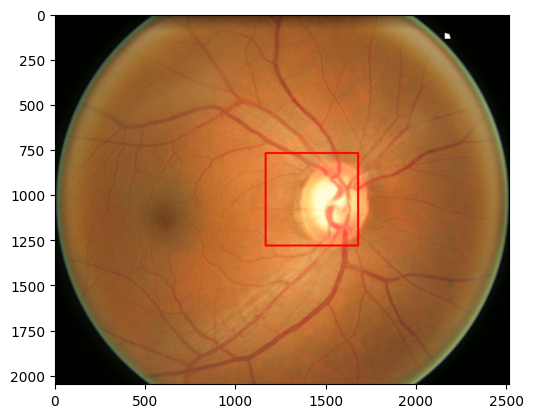

In [3]:
def intensity_weighted_centroid(image, width: int = 512, height: int = 512, channel: int = -1,
                                equalize: bool = True, clahe: bool = True, square: bool = True,
                                k_size: int = None, quantile: float = None):
    # Select the channel that is going to be used for centroid calculation
    weights = image[..., channel] if channel != -1 else cv.cvtColor(image, cv.COLOR_RGB2GRAY)

    # Equalize histogram to increase contrast
    if equalize:
        weights = cv.equalizeHist(weights)

    # Contrast Limited Adaptive Histogram Equalization
    if clahe:
        clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(10, 10))
        weights = clahe.apply(weights)

    # Convert to 32-bit float and normalize
    weights = weights.astype(np.float32)
    weights -= weights.min()
    weights = weights / weights.max()

    # Apply Gaussian blur to smooth out the image
    if k_size is not None:
        weights = cv.GaussianBlur(weights, (k_size, k_size), 0)

    # Square the weights to increase the contrast
    if square:
        weights = weights ** 2
        weights = weights / weights.sum()

    # Cut off the bottom % of the weights
    if quantile is not None:
        weights[weights < np.quantile(weights, quantile)] = 0

    # Find the centroid
    x = np.arange(0, weights.shape[1])
    y = np.arange(0, weights.shape[0])
    x, y = np.meshgrid(x, y)

    x_weighted = x * weights
    y_weighted = y * weights

    x_mean = np.sum(x_weighted) / np.sum(weights)
    y_mean = np.sum(y_weighted) / np.sum(weights)

    return int(x_mean - width / 2), int(y_mean - height / 2), width, height


img = rgb_img.copy()
x, y, w, h = intensity_weighted_centroid(
    img, 512, 512, channel=-1, equalize=True, clahe=True, square=True, k_size=65, quantile=0.9,
)
cv.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 10)
plt.imshow(img)
plt.show()

## Method 2: Brightest spot algorithm

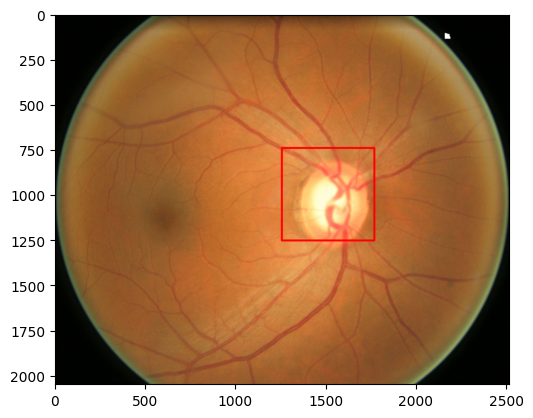

In [4]:
def brightest_spot(image, width: int = 512, height: int = 512, channel: int = -1, k_size: int = 65):
    image = cv.cvtColor(image, cv.COLOR_RGB2GRAY) if channel == -1 else image[..., channel]
    image = image.astype(np.float32) / 255.0

    # Apply Gaussian blur to smooth out the image
    blurred_img = cv.GaussianBlur(image, (k_size, k_size), 0)

    # Find the brightest spot
    max_val = np.max(blurred_img)
    max_idx = np.where(blurred_img == max_val)

    # Average the brightest spots in case there are multiple
    max_idx = np.mean(max_idx, axis=1)

    # Find the centroid of the brightest spot
    center_x = np.mean(max_idx[1])
    center_y = np.mean(max_idx[0])

    return int(center_x - width / 2), int(center_y - height / 2), width, height


img = rgb_img.copy()
x, y, w, h = brightest_spot(img, 512, 512, channel=-1, k_size=65)
cv.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 10)
plt.imshow(img)
plt.show()

## Method 3: Cuckoo Search Algorithm

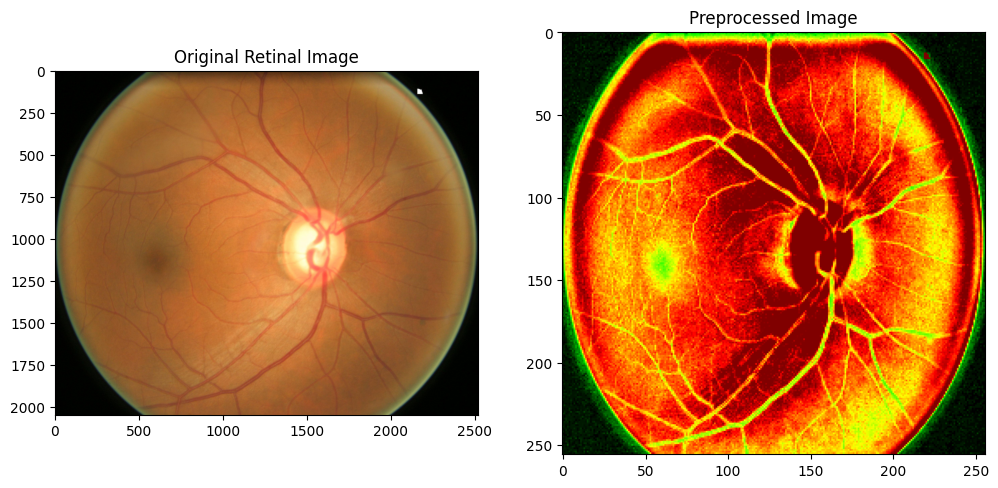

In [5]:
def cuckoo_search(image):
    # Step 1: Adaptive Histogram Equalization
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(10, 10))
    equalized_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    equalized_image = clahe.apply(equalized_image)

    # Step 2: Contrast Enhancement
    alpha = 1.5  # adjust this value for contrast enhancement
    beta = 25  # adjust this value for brightness
    contrast_enhanced_image = cv.convertScaleAbs(equalized_image, alpha=alpha, beta=beta)

    # Step 3: Resize to 256x256
    target_size = (256, 256)
    resized_image = cv.resize(contrast_enhanced_image, target_size)

    # Step 4: Transform to Jet Color Map
    jet_color_map = cv.applyColorMap(resized_image, cv.COLORMAP_JET)

    # Step 5: Nullify the Blue Channel
    jet_color_map[:, :, 0] = 0

    return jet_color_map


retinal_image = bgr_img.copy()
jet_color_map = cuckoo_search(retinal_image)

# Display the original and preprocessed images
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(cv.cvtColor(retinal_image, cv.COLOR_BGR2RGB))
plt.title('Original Retinal Image')

plt.subplot(122)
plt.imshow(cv.cvtColor(jet_color_map, cv.COLOR_BGR2RGB))
plt.title('Preprocessed Image')
plt.show()

## Method 4: Template Matching

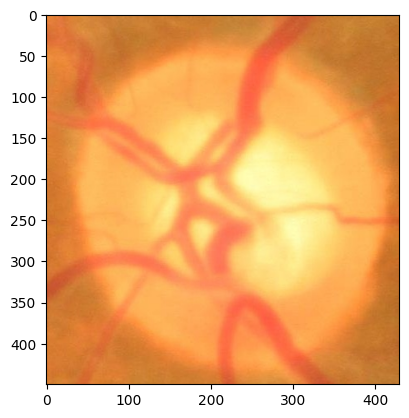

In [6]:
# Load the templates
bounds = {
    0: (800, 1300, 1350, 1750),
    1: (650, 1150, 850, 1250),
    2: (700, 1200, 750, 1250),
    3: (750, 1250, 1400, 1850),
    4: (770, 1220, 750, 1180),
    20: (670, 1180, 650, 1100),
    21: (600, 1100, 1050, 1500),
    22: (720, 1170, 1070, 1500),
}
templates = []
for idx, bound in bounds.items():
    file = os.path.join(base_dir, files[idx])
    bgr_img = cv.imread(file)
    rgb_img = cv.cvtColor(bgr_img, cv.COLOR_BGR2RGB)
    template = rgb_img.copy()[bound[0]:bound[1], bound[2]:bound[3], :]
    templates.append(template)

template = templates[-1]
plt.imshow(template)
plt.show()

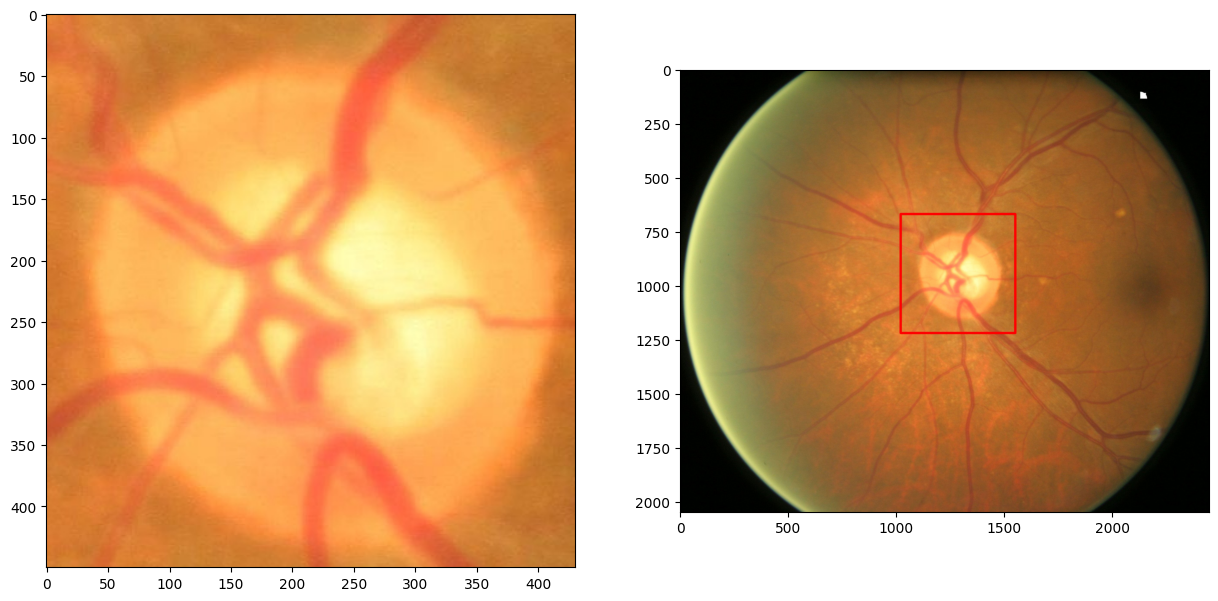

In [7]:
def template_matching(image, template, margin_x: int = 50, margin_y: int = 50):
    # Apply template Matching
    result = cv.matchTemplate(image, template, cv.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)

    # Draw the rectangle
    top_left = max_loc
    bottom_right = (top_left[0] + template.shape[1], top_left[1] + template.shape[0])

    top_left_x = top_left[0] - margin_x
    top_left_y = top_left[1] - margin_y
    width = bottom_right[0] - top_left[0] + 2 * margin_x
    height = bottom_right[1] - top_left[1] + 2 * margin_y

    return top_left_x, top_left_y, width, height


img = rgb_img.copy()
x, y, w, h = template_matching(img, template, margin_x=50, margin_y=50)
img = cv.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 10)

# Plot
_, ax = plt.subplots(1, 2, figsize=(15, 8))
ax = ax.ravel()
ax[0].imshow(template)
ax[1].imshow(img)
plt.show()

## Method 5: Thresholding channel

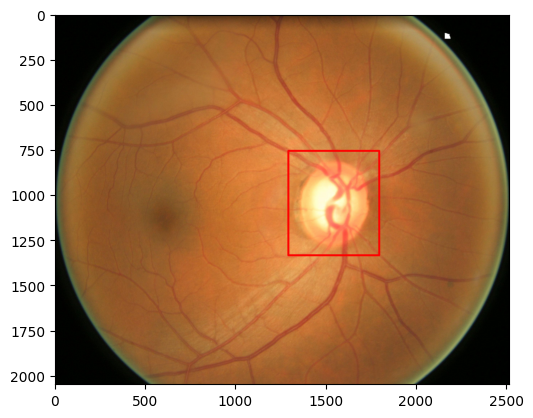

In [13]:
from utils import keep_largest_component, get_bounding_box


def threshold_channel(image, margin_x: int = 50, margin_y: int = 50, channel: int = 2,
                      crop_size: int | float = 512, k_size: int = 35):
    # Crop the image to remove the black background
    if isinstance(crop_size, float):
        crop_size = int(crop_size * image.shape[0])
    image = image[crop_size: -crop_size, crop_size: -crop_size, :]

    # Get the specified channel (red, green, blue, or grey)
    image = cv.cvtColor(image, cv.COLOR_RGB2GRAY) if channel == -1 else image[..., channel]

    # Otsu thresholding
    _, image = cv.threshold(image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    # Dilate the mask
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (k_size, k_size))
    image = cv.dilate(image, kernel)

    # Get bounding box of largest connected component
    image = keep_largest_component(image)
    top_left_x, top_left_y, width, height = get_bounding_box(image)

    top_left_x += crop_size - margin_x
    top_left_y += crop_size - margin_y
    width += 2 * margin_x
    height += 2 * margin_y

    return top_left_x, top_left_y, width, height


img = rgb_img.copy()
x, y, w, h = threshold_channel(img, channel=2, crop_size=500, k_size=35)
cv.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 10)
plt.imshow(img)
plt.show()


# Comparing methods

In [20]:
for file in files[:50]:
    bgr_img = cv.imread(os.path.join(base_dir, file))
    rgb_img = cv.cvtColor(bgr_img, cv.COLOR_BGR2RGB)

    result = rgb_img.copy()

    x, y, w, h = intensity_weighted_centroid(
        rgb_img, 512, 512, channel=-1, equalize=True, clahe=True, square=True, k_size=65, quantile=0.9,
    )
    cv.rectangle(result, (x, y), (x + w, y + h), (255, 0, 0), 10)
    cv.putText(result, 'Intensity Weighted Centroid', (10, 100), cv.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 10)

    x, y, w, h = brightest_spot(rgb_img, 512, 512, channel=-1, k_size=65)
    cv.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 10)
    cv.putText(result, 'Brightest Spot', (10, 200), cv.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 10)

    x, y, w, h = template_matching(rgb_img, template, margin_x=50, margin_y=50)
    cv.rectangle(result, (x, y), (x + w, y + h), (0, 0, 255), 10)
    cv.putText(result, 'Template Matching', (10, 300), cv.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 10)

    x, y, w, h = threshold_channel(rgb_img, channel=2, crop_size=500, k_size=35)
    cv.rectangle(result, (x, y), (x + w, y + h), (0, 255, 255), 10)
    cv.putText(result, 'Thresholding Channel', (10, 400), cv.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 255), 10)

    result = cv.cvtColor(result, cv.COLOR_RGB2BGR)
    cv.imwrite(f'../logs/{file}', result)

    # plt.figure(figsize=(12, 6))
    # plt.imshow(result)
    # plt.show()
    # break

KeyboardInterrupt: 